<a href="https://colab.research.google.com/github/jrgreen7/SYSC4906/blob/master/W2025/Tutorials/T8/Tutorial-8_ActiveLearning.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 8 - Active Learning

**Course:** SYSC 4415 - Introduction to Machine Learning

**Semester:** Winter 2025

**Adapted by:** [Kevin Dick](https://kevindick.ai/), [Igor Bogdanov](igorbogdanov@cmail.carleton.ca)

**Part II adapted from:** Clay Woolam <clay@woolam.org> under a BSD License.

---
## Active Learning

Active learning is a machine learning approach useful when labeled data is limited or costly to obtain. The process starts by training a model using the available labeled data. This model then predicts labels on a typically larger set of unlabeled instances. From these predictions, the model identifies instances where it's least confident (most uncertain predictions). A human expert (often called an "oracle") labels these uncertain data points, expanding the labeled dataset.

The model is then retrained using the expanded labeled dataset, refining its predictions. This cycle—selecting uncertain data points, querying an oracle, and retraining—is repeated iteratively until a stopping criterion (such as accuracy threshold or labeling budget) is satisfied.

### Illustrative Example (Handwritten Digits using Label Propagation)

In this tutorial, we demonstrate an active learning-inspired approach applied to handwritten digit classification using a semi-supervised method known as "label propagation":

1. Start by training a model using only 40 labeled digit images.
3. Identify the five unlabeled images where the model is least confident.
4. Obtain labels from an oracle (human annotator).
5. Retrain the model with the newly expanded dataset (initial 40 labels + 5 newly labeled instances).
6. Repeat this iterative process, incrementally growing the labeled dataset and refining model accuracy.

After multiple iterations (e.g., four iterations), the model is trained with 60 labeled instances, significantly improving accuracy compared to the initial model trained on just 40 labels.

Note: you can increase this to label more than 60 by changing `max_iterations`. Labeling more than 60 can be useful to get a sense of the speed of convergence of this active learning technique.

A plot illustrates the top five most uncertain digits chosen at each iteration, visualizing the model's progressive improvement. 

Full dataset shape: (1797, 64)
Number of samples in full dataset: 1797
Total elements in the array: 115008


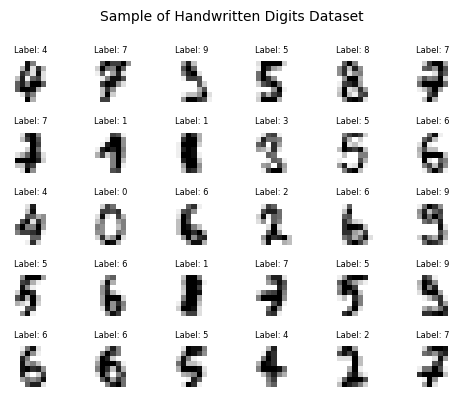

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

get_ipython().run_line_magic("matplotlib", "inline")

from sklearn import datasets
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

# Load the dataset and shuffle the order of data
digits = datasets.load_digits()
rng = np.random.RandomState(0)
indices = np.arange(len(digits.data))
rng.shuffle(indices)

print(
    "Full dataset shape:", digits.data.shape
)  # Shows dimensions (n_samples, n_features)
print("Number of samples in full dataset:", len(digits.data))
print("Total elements in the array:", digits.data.size)  # Total number of elements

# Define subset size
subset_size = 500

# Grab a subset of the data (500 random labeled samples)
X = digits.data[indices[:subset_size]]
y = digits.target[indices[:subset_size]]  # This is where the labels are stored
images = digits.images[indices[:subset_size]]

# Display a sample of the dataset
fig, axes = plt.subplots(5, 6, figsize=(5, 4))  # Reduced from (10, 8) to (5, 4)

# Ensure we have exactly 30 samples
sample_indices = rng.choice(len(images), 30, replace=False)

# Flatten the axes array for easier iteration
axes_flat = axes.flatten()

# Iterate through each sample and corresponding axis
for i in range(30):
    ax = axes_flat[i]
    idx = sample_indices[i]
    ax.imshow(images[idx], cmap=plt.cm.gray_r)
    ax.set_title(f"Label: {y[idx]}", fontsize=6)  # Reduced font size from 8 to 6
    ax.axis("off")

plt.suptitle(
    "Sample of Handwritten Digits Dataset", fontsize=10
)  # Reduced title font size
plt.tight_layout()

plt.show()

### Begin Active Learning

We run through four iterations of model refinement and then summarize the results.


In [2]:
print("\nDataset Info:")
print(f"Total samples in subset: {len(y)}")
print(f"Image shape: {images[0].shape}")
print(f"Number of classes: {len(np.unique(y))}")

n_total_samples = len(y)
n_labeled_points = 40  # Start with 40 labelled points

max_iterations = 5  # Add 5 newly labelled points at each iteration.

unlabeled_indices = np.arange(n_total_samples)[
    n_labeled_points:
]  # Create nparray of indices between 40..499

f = plt.figure()

print(f"Initial labeled points: {n_labeled_points}")

# Create arrays to store results across all iterations
all_accuracies = []
all_labeled_counts = []
all_models = []
all_uncertain_indices = []
all_confusion_matrices = []



Dataset Info:
Total samples in subset: 500
Image shape: (8, 8)
Number of classes: 10
Initial labeled points: 40


In [13]:
# Step 1: Train initial model with only 40 labeled samples
print("\n\n# Step 1: Train initial model with only 40 labeled samples")
print("=" * 70)

# Create training data with only 40 labeled samples
y_train = np.copy(y)
y_train[unlabeled_indices] = -1  # Mark unlabeled samples with -1

# Train a label propagation model
print(f"Training initial model with {n_labeled_points} labeled samples...")
lp_model = LabelSpreading(gamma=0.25, max_iter=20)
lp_model.fit(X, y_train)

# Evaluate initial model on unlabeled data
predicted_labels = lp_model.transduction_[unlabeled_indices]
true_labels = y[unlabeled_indices]


# Compute the confusion matrix for initial model
cm_initial = confusion_matrix(true_labels, predicted_labels, labels=lp_model.classes_)

# Store results for iteration 0
all_models.append(lp_model)
all_accuracies.append(accuracy_score(true_labels, predicted_labels))
all_labeled_counts.append(n_labeled_points)
all_confusion_matrices.append(cm_initial)

# Print initial model performance
print(f"Initial model trained with {n_labeled_points} labeled samples")
print(f"Unlabeled samples: {len(unlabeled_indices)}")
print(f"Total samples: {n_total_samples}")
print("\nInitial model performance on unlabeled data:")
print(classification_report(true_labels, predicted_labels))

print("\nConfusion matrix for initial model:")
print(cm_initial)


# Get actual values from the confusion matrix for digit 3
digit_to_explain = 3  # We'll use digit 3 as our example
true_positives = cm_initial[digit_to_explain, digit_to_explain]
false_negatives = sum(cm_initial[digit_to_explain, :]) - true_positives
false_positives = sum(cm_initial[:, digit_to_explain]) - true_positives
true_negatives = cm_initial.sum() - true_positives - false_positives - false_negatives

# Calculate metrics
precision = (
    true_positives / (true_positives + false_positives)
    if (true_positives + false_positives) > 0
    else 0
)
recall = (
    true_positives / (true_positives + false_negatives)
    if (true_positives + false_negatives) > 0
    else 0
)
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Add explanation of confusion matrix metrics with actual values
print("\nUnderstanding Confusion Matrix Metrics:")
print("For Multi-class Classification (Your Digit Recognition Case)")
print(
    "In a multi-class problem like digit recognition (0-9), we can calculate metrics for each digit separately:"
)
print(f'\nFor a specific digit (e.g., digit "{digit_to_explain}"):')
print(f'True Positives (TP): The number of actual "{digit_to_explain}"s correctly classified as "{digit_to_explain}"')
print(f'  This is the diagonal element for class "{digit_to_explain}" ({true_positives} in the generated matrix)')

print(f'False Positives (FP): The number of non-"{digit_to_explain}" digits incorrectly classified as "{digit_to_explain}"')
print(f'  This is the sum of all other values in the "{digit_to_explain}" column (excluding the diagonal): {false_positives}')

print(f'False Negatives (FN): The number of actual "{digit_to_explain}"s incorrectly classified as something else')
fn_details = [
    f"{cm_initial[digit_to_explain, j]} as {j}"
    for j in range(10)
    if j != digit_to_explain and cm_initial[digit_to_explain, j] > 0
]
fn_details_str = " + ".join(fn_details)
print(f'  This is the sum of all other values in the "{digit_to_explain}" row (excluding the diagonal): {false_negatives} ({fn_details_str})')

print(f'True Negatives (TN): The number of non-"{digit_to_explain}" digits correctly classified as non-"{digit_to_explain}"')
print(f"  This is the sum of all other diagonal elements: {true_negatives}")

print(f"\nDerived metrics for digit {digit_to_explain}:")
print(f"Precision: {precision:.4f} (How many predicted {digit_to_explain}s are actually {digit_to_explain}s)")
print(f"Recall: {recall:.4f} (How many actual {digit_to_explain}s were correctly identified)")
print(f"F1 Score: {f1:.4f} (Harmonic mean of precision and recall)")




# Step 1: Train initial model with only 40 labeled samples
Training initial model with 40 labeled samples...
Initial model trained with 40 labeled samples
Unlabeled samples: 460
Total samples: 500

Initial model performance on unlabeled data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.91      0.71      0.80        42
           2       1.00      0.98      0.99        46
           3       0.97      0.65      0.78        49
           4       0.93      1.00      0.96        40
           5       0.98      0.88      0.93        51
           6       0.88      0.98      0.92        50
           7       0.96      1.00      0.98        46
           8       0.78      0.96      0.86        49
           9       0.71      0.85      0.78        47

    accuracy                           0.90       460
   macro avg       0.91      0.90      0.90       460
weighted avg       0.91      0.90      0.90       4

In [4]:
# Step 2: Identify uncertain samples (Active Learning selection strategy)
print("\n\n# Step 2: Identify uncertain samples (Active Learning selection strategy)")
print("=" * 70)

# Compute uncertainty using entropy of predicted probability distributions
print("Computing uncertainty for each unlabeled sample...")
pred_entropies = stats.distributions.entropy(lp_model.label_distributions_.T)

# Select the 5 most uncertain samples
uncertainty_index = np.argsort(pred_entropies)[::-1]
uncertainty_index = uncertainty_index[np.in1d(uncertainty_index, unlabeled_indices)][:5]

all_uncertain_indices.append(uncertainty_index)

print(f"Selected {len(uncertainty_index)} most uncertain samples")
print("Entropy values for selected samples:")
for idx in uncertainty_index:
    print(f"  Sample {idx}: Entropy = {pred_entropies[idx]:.4f}, True label = {y[idx]}")



# Step 2: Identify uncertain samples (Active Learning selection strategy)
Computing uncertainty for each unlabeled sample...
Selected 5 most uncertain samples
Entropy values for selected samples:
  Sample 324: Entropy = 0.6933, True label = 9
  Sample 81: Entropy = 0.2880, True label = 3
  Sample 479: Entropy = 0.2872, True label = 3
  Sample 227: Entropy = 0.2850, True label = 3
  Sample 486: Entropy = 0.2678, True label = 3




# Step 3: Visualize the uncertain samples (simulating oracle labeling)


<Figure size 640x480 with 0 Axes>

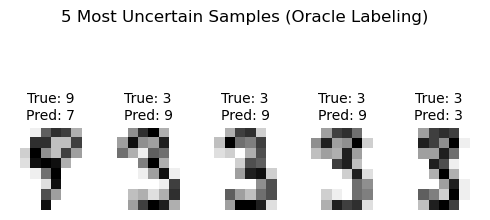

In [5]:
# Step 3: Visualize the uncertain samples (simulating oracle labeling)
print("\n\n# Step 3: Visualize the uncertain samples (simulating oracle labeling)")
print("=" * 70)

# Create a figure to display the uncertain samples
plt.figure(figsize=(5, 3))
for i, idx in enumerate(uncertainty_index):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[idx], cmap=plt.cm.gray_r)
    plt.title(f"True: {y[idx]}\nPred: {lp_model.transduction_[idx]}", fontsize=10)
    plt.axis("off")
plt.suptitle("5 Most Uncertain Samples (Oracle Labeling)", fontsize=12)
plt.tight_layout()
plt.show()

In [6]:
# Step 4: Update labeled dataset with oracle labels
print("\n\n# Step 4: Update labeled dataset with oracle labels")
print("=" * 70)

# Track indices to remove from unlabeled set
delete_indices = np.array([], dtype=int)
for idx in uncertainty_index:
    # Find position in unlabeled_indices array
    (delete_index,) = np.where(unlabeled_indices == idx)
    delete_indices = np.concatenate((delete_indices, delete_index))

# Update the sets
old_n_labeled = n_labeled_points
unlabeled_indices = np.delete(unlabeled_indices, delete_indices)
n_labeled_points += len(uncertainty_index)

print(f"Added {len(uncertainty_index)} new labeled samples")
print(f"Labeled samples increased from {old_n_labeled} to {n_labeled_points}")
print(f"Remaining unlabeled samples: {len(unlabeled_indices)}")



# Step 4: Update labeled dataset with oracle labels
Added 5 new labeled samples
Labeled samples increased from 40 to 45
Remaining unlabeled samples: 455


In [7]:
# Step 5: Re-train model with expanded labeled dataset
print("\n\n# Step 5: Re-train model with expanded labeled dataset")
print("=" * 70)

# Create updated training data
y_train = np.copy(y)
y_train[unlabeled_indices] = -1  # Mark remaining unlabeled samples with -1

# Train updated model
print(f"Training updated model with {n_labeled_points} labeled samples...")
lp_model_updated = LabelSpreading(gamma=0.25, max_iter=20)
lp_model_updated.fit(X, y_train)

# Evaluate updated model
predicted_labels_updated = lp_model_updated.transduction_[unlabeled_indices]
true_labels_updated = y[unlabeled_indices]

# Compute the confusion matrix for updated model
cm_updated = confusion_matrix(
    true_labels_updated, predicted_labels_updated, labels=lp_model_updated.classes_
)

# Store results for iteration 1
all_models.append(lp_model_updated)
all_accuracies.append(accuracy_score(true_labels_updated, predicted_labels_updated))
all_labeled_counts.append(n_labeled_points)
all_confusion_matrices.append(cm_updated)

print(f"Updated model trained with {n_labeled_points} labeled samples")
print("\nUpdated model performance on remaining unlabeled data:")
print(classification_report(true_labels_updated, predicted_labels_updated))

print("\nConfusion matrix for updated model:")
print(cm_updated)



# Step 5: Re-train model with expanded labeled dataset
Training updated model with 45 labeled samples...
Updated model trained with 45 labeled samples

Updated model performance on remaining unlabeled data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.91      0.71      0.80        42
           2       1.00      0.98      0.99        46
           3       0.97      0.84      0.90        45
           4       0.93      1.00      0.96        40
           5       1.00      0.75      0.85        51
           6       0.88      0.98      0.92        50
           7       1.00      1.00      1.00        46
           8       0.82      0.96      0.89        49
           9       0.72      0.91      0.81        46

    accuracy                           0.91       455
   macro avg       0.92      0.91      0.91       455
weighted avg       0.92      0.91      0.91       455


Confusion matrix for updated mo

In [8]:
# Step 6: Compare initial and updated model performance
print("\n\n# Step 6: Compare initial and updated model performance")
print("=" * 70)

# Calculate accuracy for both models

initial_accuracy = all_accuracies[0]
updated_accuracy = all_accuracies[1]

print(f"Initial model accuracy (40 labeled samples): {initial_accuracy:.4f}")
print(f"Updated model accuracy (45 labeled samples): {updated_accuracy:.4f}")
print(f"Accuracy improvement: {(updated_accuracy - initial_accuracy) * 100:.2f}%")



# Step 6: Compare initial and updated model performance
Initial model accuracy (40 labeled samples): 0.9000
Updated model accuracy (45 labeled samples): 0.9121
Accuracy improvement: 1.21%




# Step 7: Continue with iterative process
The active learning process continues iteratively:
1. Identify uncertain samples
2. Get oracle labels
3. Update labeled dataset
4. Retrain model
5. Evaluate improvement
This cycle repeats until a stopping criterion is met (e.g., accuracy threshold or labeling budget).

Iteration 2:
--------------------------------------------------
Model trained with 50 labeled samples
Accuracy: 0.9378
Improvement from initial: 3.78%

Iteration 3:
--------------------------------------------------
Model trained with 55 labeled samples
Accuracy: 0.9348
Improvement from initial: 3.48%

Iteration 4:
--------------------------------------------------
Model trained with 60 labeled samples
Accuracy: 0.9409
Improvement from initial: 4.09%


# Visualization of Active Learning Iterations


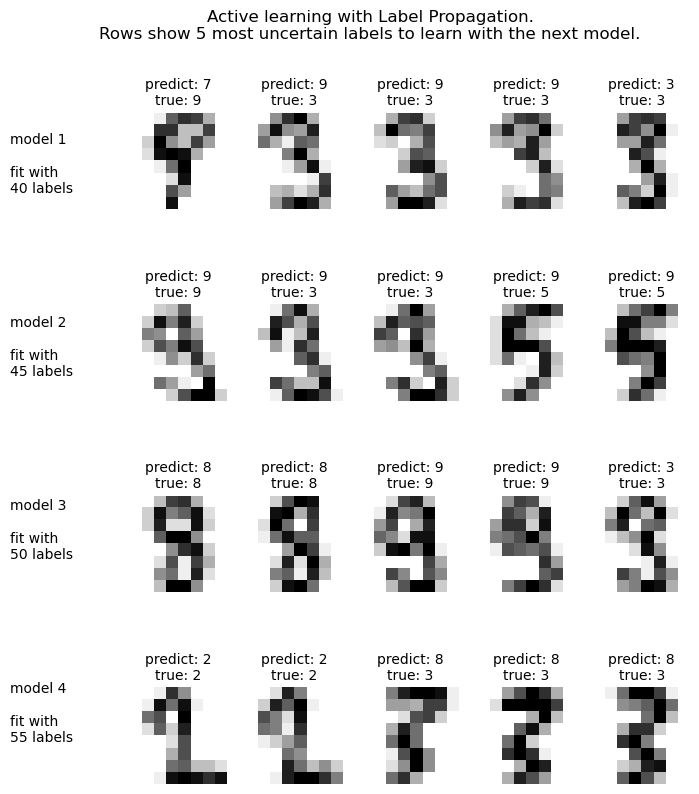

In [9]:
# Step 7: Continue with iterative process
print("\n\n# Step 7: Continue with iterative process")
print("=" * 70)
print("The active learning process continues iteratively:")
print("1. Identify uncertain samples")
print("2. Get oracle labels")
print("3. Update labeled dataset")
print("4. Retrain model")
print("5. Evaluate improvement")
print(
    "This cycle repeats until a stopping criterion is met (e.g., accuracy threshold or labeling budget)."
)

for i in range(2, max_iterations):
    print(f"\nIteration {i}:")
    print("-" * 50)

    # Get current model and unlabeled indices
    current_model = all_models[-1]

    # Compute uncertainty
    pred_entropies = stats.distributions.entropy(current_model.label_distributions_.T)
    uncertainty_index = np.argsort(pred_entropies)[::-1]
    uncertainty_index = uncertainty_index[
        np.in1d(uncertainty_index, unlabeled_indices)
    ][:5]
    all_uncertain_indices.append(uncertainty_index)

    # Update labeled set
    delete_indices = np.array([], dtype=int)
    for idx in uncertainty_index:
        (delete_index,) = np.where(unlabeled_indices == idx)
        delete_indices = np.concatenate((delete_indices, delete_index))

    unlabeled_indices = np.delete(unlabeled_indices, delete_indices)
    n_labeled_points += len(uncertainty_index)

    # Train and evaluate new model
    y_train = np.copy(y)
    y_train[unlabeled_indices] = -1
    new_model = LabelSpreading(gamma=0.25, max_iter=20)
    new_model.fit(X, y_train)

    # Evaluate
    preds = new_model.transduction_[unlabeled_indices]
    true = y[unlabeled_indices]
    acc = accuracy_score(true, preds)
    cm = confusion_matrix(true, preds, labels=new_model.classes_)

    # Store results
    all_models.append(new_model)
    all_accuracies.append(acc)
    all_labeled_counts.append(n_labeled_points)
    all_confusion_matrices.append(cm)

    print(f"Model trained with {n_labeled_points} labeled samples")
    print(f"Accuracy: {acc:.4f}")
    print(f"Improvement from initial: {(acc - initial_accuracy) * 100:.2f}%")

# Create visualization of all iterations (similar to original implementation)
print("\n\n# Visualization of Active Learning Iterations")
print("=" * 70)

# Reset variables to initial state
n_labeled_points = 40
unlabeled_indices = np.arange(n_total_samples)[n_labeled_points:]

# Create figure for visualization
f = plt.figure(figsize=(8, 10))


# Visualize the uncertain samples for each iteration
for i in range(min(5, len(all_uncertain_indices))):
    # Add iteration label
    f.text(
        0.05,
        (1 - (i + 1) * 0.183),
        f"model {i+1}\n\nfit with\n{all_labeled_counts[i]} labels",
        size=10,
    )

    # Add the 5 most uncertain samples
    for j, idx in enumerate(all_uncertain_indices[i]):
        sub = f.add_subplot(5, 5, j + 1 + (5 * i))
        sub.imshow(images[idx], cmap=plt.cm.gray_r, interpolation="none")
        sub.set_title(
            f"predict: {all_models[i].transduction_[idx]}\ntrue: {y[idx]}",
            size=10,
        )
        sub.axis("off")

# Add title to the visualization
f.suptitle(
    "Active learning with Label Propagation.\nRows show 5 most "
    "uncertain labels to learn with the next model.",
    y=1,
)
plt.subplots_adjust(left=0.2, bottom=0.03, right=0.9, top=0.9, wspace=0.2, hspace=0.85)
plt.show()



# Quantitative Results Across Active Learning Iterations
Iteration 0 (Initial): 40 labeled samples, Accuracy: 0.9000
Iteration 1: 45 labeled samples, Accuracy: 0.9121 (+1.21%)
Iteration 2: 50 labeled samples, Accuracy: 0.9378 (+3.78%)
Iteration 3: 55 labeled samples, Accuracy: 0.9348 (+3.48%)
Iteration 4: 60 labeled samples, Accuracy: 0.9409 (+4.09%)


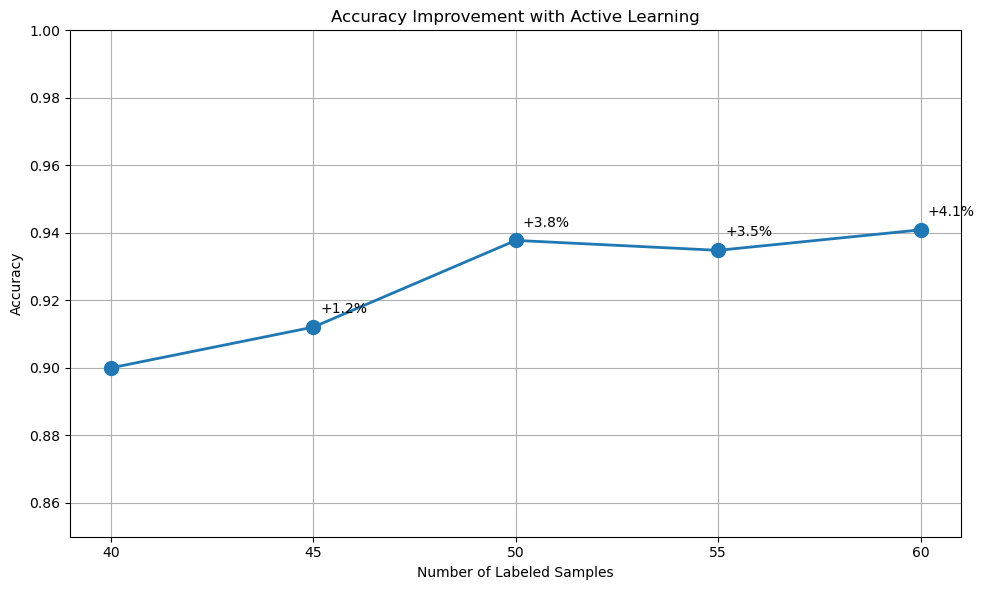

In [10]:
# Add comprehensive results comparison
print("\n# Quantitative Results Across Active Learning Iterations")
print("=" * 70)

# Print accuracy for each iteration
for i in range(len(all_accuracies)):
    if i == 0:
        print(
            f"Iteration {i} (Initial): {all_labeled_counts[i]} labeled samples, Accuracy: {all_accuracies[i]:.4f}"
        )
    else:
        improvement = (all_accuracies[i] - all_accuracies[0]) * 100
        print(
            f"Iteration {i}: {all_labeled_counts[i]} labeled samples, Accuracy: {all_accuracies[i]:.4f} (+{improvement:.2f}%)"
        )

# Plot accuracy improvement
plt.figure(figsize=(10, 6))
plt.plot(all_labeled_counts, all_accuracies, "o-", linewidth=2, markersize=10)
plt.xlabel("Number of Labeled Samples")
plt.ylabel("Accuracy")
plt.title("Accuracy Improvement with Active Learning")
plt.grid(True)
plt.xticks(all_labeled_counts)
plt.ylim(min(all_accuracies) - 0.05, 1.0)

# Add percentage improvement annotations
for i in range(1, len(all_accuracies)):
    improvement = (all_accuracies[i] - all_accuracies[0]) * 100
    plt.annotate(
        f"+{improvement:.1f}%",
        xy=(all_labeled_counts[i], all_accuracies[i]),
        xytext=(5, 10),
        textcoords="offset points",
    )

plt.tight_layout()
plt.show()

**Q:** Are the **most uncertain** samples those *closest-to*, *furthest-from*, or *neither* from the **decision boundary**?

# Takeaway Messages

* Active learniing is useful when only a **limited amount of labelled data** are available to train a model.
* An Active Learning model is trained using the following steps:
1.   train model on **available labelled data**
2.   **apply model** to **unlabelled** samples
3.   pick a set of **least certain samples**, 
4.   **query an oracle** to obtain **labels**
5.   **retrain** the model
6.   (**Repeat** until a **stop criterion**)